In [18]:
#初始化
import numpy as np
import os
import tarfile
import sklearn
import csv
import math
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["font.family"]="Times New Roman"
np.random.seed(42)
from scipy.interpolate import splev
import seaborn as sns
import os

In [2]:
#读取数据
database_name="data2"
# database_name="all"

model_name="ET"
def load_data(name):
    location="./data/"+name+".csv"
    data=pd.read_csv(location,sep=",").iloc[:,:]
    return data

In [3]:
data_org=load_data(database_name)
data_x,data_y=data_org.iloc[:,:-1],data_org.iloc[:,-1]

In [4]:
ratio=0.35

In [20]:
#划分测试集（暂定随机抽样）
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
x_train_full, x_test, y_train_full, y_test = train_test_split(data_x,data_y,test_size=ratio, random_state=42)
x_train, x_valid, y_train, y_valid = train_test_split(x_train_full, y_train_full, test_size=0.15,random_state=42)

In [8]:
print(x_train.shape,x_test.shape,x_valid.shape)

(85, 3) (55, 3) (16, 3)


In [9]:
#对随机森林进行参数调整
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import GridSearchCV


#输入超参数组
param_grid = [{'n_estimators': range(50,150,5),
              'max_depth': range(5,20,2),
              "max_features":["auto","sqrt","log2"],
              "min_samples_split":range(2,10,2),
               "min_impurity_decrease":[0,0.05,0.1]
              }]
forest_reg = ExtraTreesRegressor(random_state=42,max_depth=15)#设置好随机森林模型
grid_search_n = GridSearchCV(forest_reg, param_grid, cv=5,n_jobs=5,
                           scoring='neg_mean_squared_error', return_train_score=True)
#将模型赋给gridsearch
grid_search_n.fit(x_train, y_train)#将数据传入


GridSearchCV(cv=5, estimator=ExtraTreesRegressor(max_depth=15, random_state=42),
             n_jobs=5,
             param_grid=[{'max_depth': range(5, 20, 2),
                          'max_features': ['auto', 'sqrt', 'log2'],
                          'min_impurity_decrease': [0, 0.05, 0.1],
                          'min_samples_split': range(2, 10, 2),
                          'n_estimators': range(50, 150, 5)}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [10]:
best_params_n=grid_search_n.best_params_['n_estimators']
best_params_d=grid_search_n.best_params_['max_depth']
best_params_f=grid_search_n.best_params_['max_features']
best_params_s=grid_search_n.best_params_['min_samples_split']
best_params_i=grid_search_n.best_params_['min_impurity_decrease']
print(best_params_n,best_params_d,best_params_f,best_params_s,best_params_i)

60 11 sqrt 2 0


In [201]:
#输入超参数组合
param_grid = [{'max_depth': range(1,30,1)}]
forest_reg = ExtraTreesRegressor(random_state=42,n_estimators=best_params_n)#设置好随机森林模型
grid_search_d = GridSearchCV(forest_reg, param_grid, cv=5,n_jobs=5,
                           scoring='neg_mean_squared_error', return_train_score=True)
#将模型赋给gridsearch
grid_search_d.fit(x_train_full, y_train_full)#将数据传入

best_params_depth=grid_search_d.best_params_['max_depth']

In [13]:
#param:输入的字典数据，记录了调参结果，x:输入的是n调参还是d调参，save:是否保存
def save_paramdata(param_dict,x,save):
    data=pd.DataFrame(param_dict)

    data["rmse_train"]=np.sqrt(-data['mean_train_score'])
    data["rmse_test"]=np.sqrt(-data['mean_test_score'])
    data["STDrmse_train"]=((data["rmse_train"]-data["rmse_train"].min())/(data["rmse_train"].max()-data["rmse_train"].min()))
    data["STDrmse_test"]=((data["rmse_test"]-data["rmse_test"].min())/(data["rmse_test"].max()-data["rmse_test"].min()))
    if x=="n":
        data["param"]=param_dict["param_n_estimators"]        
        param_name="_N"
    if x=="d":
        data["param"]=param_dict["param_max_depth"] 
        param_name="_D"
    if save==1:
        save_name=model_name+"_"+database_name+"_"+str(HR)+param_name
        data.to_csv("./result/train/param/"+save_name+".csv")
    return data

In [40]:
print("n:",best_params_n,"d:",best_params_depth)
cvres_n=grid_search_n.cv_results_
cvres_d=grid_search_d.cv_results_

NameError: name 'best_params_depth' is not defined

In [169]:
data_n=save_paramdata(cvres_n,"n",0)
data_d=save_paramdata(cvres_d,"d",0)

In [95]:
#随着参数变化RMSE变化趋势，a:输入的矩阵，param_name:是对n_estimator求还是max_depth，xs图中剪头位置，save:是否保存，1为保存
def draw_param(a,param_name,xs,save):
    from matplotlib.ticker import MultipleLocator, FormatStrFormatter
    fig,ax=plt.subplots(figsize=(6,3))
    ax2=ax.twinx()
    lns1=ax.plot(a["param"],a["rmse_train"],'r-',label="Train",linewidth=1,
                 marker="+",markersize=2)
    lns2=ax2.plot(a["param"],a["rmse_test"],"b-",label="Validation",linewidth=1,
                  marker="+",markersize=2)
    lns=lns1+lns2
    labs = [l.get_label() for l in lns]
    #设置轴
    ax.set_xlim(a["param"].min()-2,a["param"].max()+2)
    xlim=math.ceil((a["param"].max()-a["param"].min())/5)
    dertay=(a["rmse_train"].max()-a["rmse_train"].min())
    ymin=a["rmse_train"].min()
    print(a["rmse_test"].min())
    print(a["rmse_test"].max())
    
    xmajorLocator  = MultipleLocator(xlim) #将x主刻度标签设置为20的倍数 
    xminorLocator  = MultipleLocator(xlim/5) #将x轴次刻度标签设置为5的倍数 
    ax.xaxis.set_major_locator(xmajorLocator) 
    ax.xaxis.set_minor_locator(xminorLocator) 

    if param_name=="n":
        words=str(xs)
        xys=(xs,ymin+dertay/8)
        xytexts=(xs,ymin+dertay/2)
        xlabels="n_estimators"
        ax.legend(lns, labs, loc=2,fontsize=16)
        
    if param_name=="d":
        words=str(xs)
        xys=(xs,ymin+dertay/8)
        xytexts=(xs,ymin+dertay/2)
        xlabels="max_depth"
        ax.legend(lns, labs, loc=1,fontsize=16)
        
    ax.annotate(words, xys, xytext=xytexts, 
#                 textcoords='axes fraction',
            arrowprops=dict(facecolor='black'),fontsize=16,
            horizontalalignment='center', verticalalignment='top')
    ax.set_xlabel(xlabels,fontsize=16)
    ax.set_ylabel("RMSE(%) of Train",fontsize=18)
    ax2.set_ylabel("RMSE(%) of Validation",fontsize=18)

    ax.tick_params(labelsize=16)
    ax2.tick_params(labelsize=16)
    
    if save==1:
        save_name=model_name+"_"+database_name+"_"+str(HR)+"_"+param_name
        plt.savefig(fname="./result/train/param/"+save_name+".png",dpi=150,bbox_inches="tight")

0.05927449137677313
0.16322732610156648


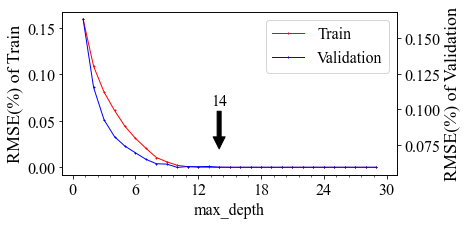

In [203]:
draw_param(data_d,"d",best_params_depth,0)

0.05939908854013022
0.08864708020386688


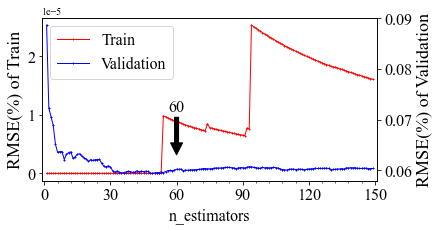

In [204]:
draw_param(data_n,"n",best_params_n,0)

In [33]:
#利用最佳参数再运行一次RF
final_forest_reg = ExtraTreesRegressor(
   n_estimators=220,max_depth=12,
#     n_estimators=best_params_n,max_depth=best_params_d,
#     min_samples_leaf=best_params_s,max_features=best_params_f,
#     min_impurity_decrease=best_params_i,
                                         random_state=42)
final_forest_reg.fit(x_train, y_train)
y_train_pred=final_forest_reg.predict(x_train)
y_pred=final_forest_reg.predict(x_test)

In [27]:
def relative_error(y_true,y_pred):
    term1=np.sqrt(np.square(y_true-y_pred).sum())
    term2=np.sqrt(np.square(y_true).sum())
    return term1/term2

In [34]:
test_r1=relative_error(y_test, y_pred)
test_r1

0.14784023378315234

In [32]:
from sklearn.metrics import mean_squared_error#导入计算误差的函数
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
test_r2= r2_score(y_test, y_pred)
test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)
print("RMSE",test_rmse)
print("R2",test_r2)

RMSE 0.042850471534739656
R2 0.9646823956684792


In [22]:
y_train.shape

(85,)

In [35]:
train_r2= r2_score(y_train, y_train_pred)
train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_r1=relative_error(y_train, y_train_pred)
train_r1

0.1596852457781241

In [ ]:
def save_test_data():
    data=pd.DataFrame({
        "Ltx":x_test["Ltx"],
        "D":x_test["D"],
        "MI":x_test["MI"],
        "y":y_test.values,
        "pred":y_pred,
        "r1":test_r1,
        "R2":test_r2,
        "RMSE":test_rmse
        
    })
    location="./result/test/performance/"
    name=model_name+"_"+database_name+"_"+str(ratio)+"_test_performance"+".csv"
    data.to_csv(location+name,header=True,mode='w')
    print("done save to",name)
    return data
test_result=save_test_data()

In [25]:
def save_train_data():
    data=pd.DataFrame({
        "Ltx":x_train["Ltx"],
        "D":x_train["D"],
        "MI":x_train["MI"],
        "y":y_train.values,
        "pred":y_train_pred,
        "r1":train_r1,
        "R2":train_r2,
        "RMSE":train_rmse
        
    })
    location="./result/test/performance/"
    name=model_name+"_"+database_name+"_"+str(ratio)+"_train_performance"+".csv"
    data.to_csv(location+name,header=True,mode='w')
    print("done save to",name)
    return data
train_result=save_train_data()

done save to ET_data2_0.35_train_performance.csv


In [15]:
data_save=pd.DataFrame({"ratio":ratio
                        ,"train":x_train.shape[0]
                        ,"test":x_test.shape[0]
                        ,"valid":x_valid.shape[0]
                        ,"r1":r1
                        ,"r2":test_r2
                        ,"RMSE":test_rmse
                       , "model":model_name},index=[0])
save_loc="./result/result.csv"
data_save.to_csv(save_loc,mode="a+",index=False,header=False)
# data_save.to_csv(save_loc,mode="a+",index=False)

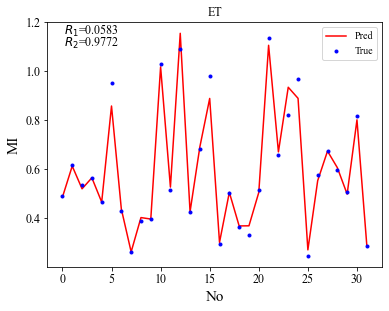

In [148]:
x_draw=np.arange(y_pred.shape[0])
fig,ax=plt.subplots(1,1,figsize=(6,4.5))
ax.tick_params(labelsize=12)
ax.plot(x_draw,y_pred,"r-",label="Pred")
ax.plot(x_draw,y_test,"b.",linewidth=5,label="True")
ax.set_xlabel("No",fontsize=15)
ax.set_ylabel("MI",fontsize=15)
ax.set_title(model_name)
ax.legend()

ax.text(0.05,0.95,s=("$R_1$="+str(round(r1,4))),fontsize=12,transform=ax.transAxes)
ax.text(0.05,0.9,s=("$R_2$="+str(round(test_r2,4))),fontsize=12,transform=ax.transAxes)


fig.savefig("./figure/"+model_name+"_"+database_name+"_"+str(round(r1,4))+"_demo.png",dpi=150,
           bbox_inches="tight")